# CENG 483 THE 2

**Name: Ahmet Eren KARDAŞ**

**Student ID: 2448579**



In [9]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import time
from scipy.signal import convolve2d




# You can use this code block (or add new code blocks here) to implement shared functionality.

True

#### images


In [89]:
image_path ="./images/chessboard.png"


input_image1 = read_image("./images/chessboard.png")
input_image3 = read_image("./images/lab.png")
input_image5 = read_image("./images/tree.png")
 
input_image2 = read_image("./images/chessboard-rotated.png")
input_image4 = read_image("./images/lab-rotated.png")
input_image6 = read_image("./images/tree-rotated.png")


## Helpers

In [90]:

# read the image
def read_image(image_path):
    image = cv2.imread(image_path)
    return image

# find total difference between two window
def window_difference(window1, window2):
    total_error = 0
    if window1.shape == window2.shape:
        for i in range(window1.shape[0]):
            for j in range(window1.shape[1]):
                total_error += np.square(window1[i][j] - window2[i][j])
    return total_error

# take maximum with windows size 9
def non_max_suppression(image, window_size=9):
    offset = window_size // 2
    height, width = image.shape

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            window = image[y-offset: y+offset+1, x-offset: x+offset+1]
            max_value = np.max(window)
            max_index = np.unravel_index(np.argmax(window), window.shape)
            window[:] = 0
            window[max_index] = max_value
            
            image[y-offset: y+offset+1, x-offset: x+offset+1] = window

    return image

# find x and y gradients of image
def find_gradients(image):
    
    kernel_x = np.array([[-1/3, 0, 1/3],[-1/3, 0, 1/3],[-1/3, 0, 1/3]])
    kernel_y = np.array([[1/3, 1/3, 1/3],[0, 0, 0],[-1/3, -1/3, -1/3]])

    Ix = convolve2d(image,kernel_x, mode="same", boundary="symm")
    Iy = convolve2d(image,kernel_y, mode="same", boundary="symm")

    return Ix, Iy

# uniform filtering
def uniform_filtering(image):

    #Uniform weighting filter
    uniform_filter = np.array([[1,1,1],[1,1,1],[1,1,1]]) / 9

    result_image = convolve2d(image, uniform_filter, mode='same', boundary="symm")

    return result_image

# circular filtering
def circular_filtering(image):

    # circular weighting filter
    circular_filter = np.array([[0,1,0], [1,1,1], [0,1,0]]) / 5

    result_image = convolve2d(image, circular_filter, mode='same', boundary="symm")

    return result_image

# gaussian filtering
def gaussian_filtering(image):

    # gaussian weighting filter
    gaussian_filter = np.array([[0.5,1,0.5], [1,2,1], [0.5,1,0.5]]) / 8

    result_image = convolve2d(image, gaussian_filter, mode='same', boundary="symm")

    return result_image



## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

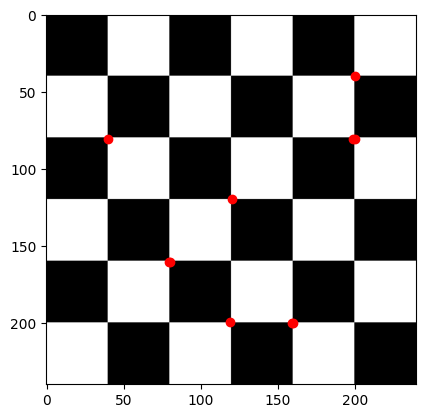

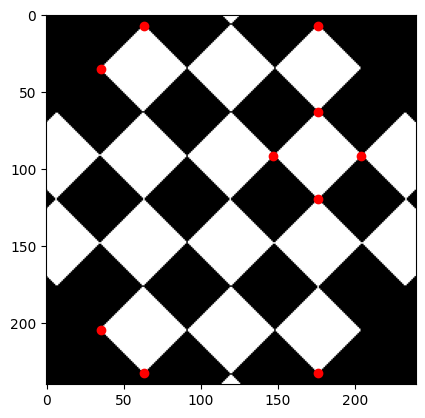

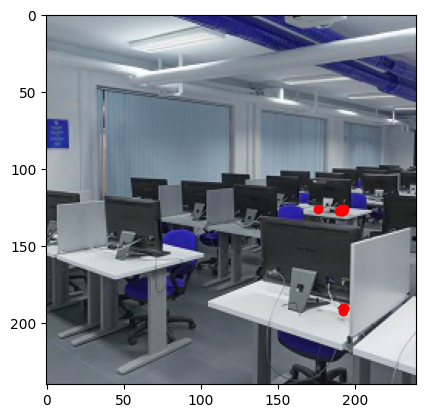

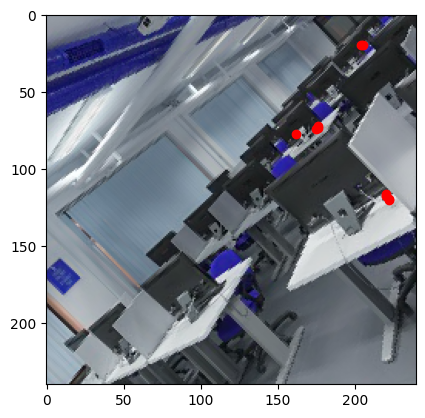

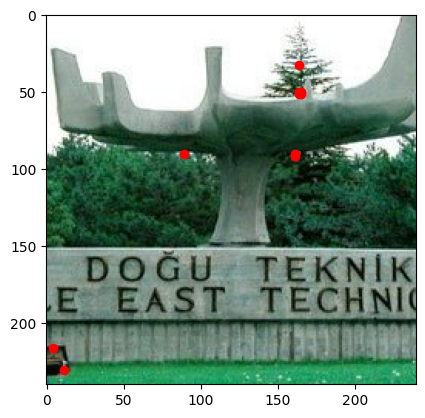

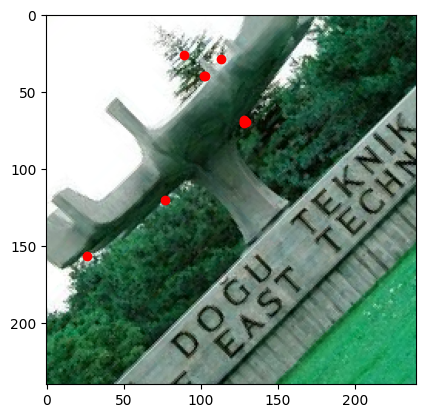

NAIVE AVERAGE TIME =  5.617363413174947


In [91]:

def naive_harris_corner_detector(image, window_size=3):
 
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    offset = window_size // 2
    height, width = gray_image.shape

    # u,v  directions
    directions = [
        [1, 1],
        [0, 1],
        [-1, 1],
        [-1, -1],
        [0, -1],
        [1, -1],
        [-1, 0],
        [1, 0]
    ]

    corners = np.zeros_like(gray_image, dtype=float)

    # move in the image and find differences for pixels 
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            window = gray_image[y-offset: y+offset+1, x-offset: x+offset+1]
            window = uniform_filtering(window)
            
            errors = np.zeros(8)
            ind = 0
            for direction in directions:
                if y-offset + direction[0] < 0 or y+offset+1 + direction[0] >= height or x-offset + direction[1] < 0 or x+offset+1 + direction[1] >= width:
                    continue

                new_window = gray_image[y-offset + direction[0]: y+offset+1 + direction[0], x-offset + direction[1]: x+offset+1 + direction[1]]
                errors[ind] = window_difference(window, new_window)
                ind += 1
            corners[y][x] = np.min(errors)

    # Find indices of the top 10 corners
    top_10_indices = np.argpartition(corners.flatten(), -10)[-10:]

    # convert indices to 2D indices to plot later
    top_10_indices_2d = np.unravel_index(top_10_indices, corners.shape)

    # Plot the image
    plt.imshow(image)
    plt.gray()

    # Plot the top 10 corners on the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()

naive_begin = time.time()
naive_harris_corner_detector(input_image1)
naive_harris_corner_detector(input_image2)
naive_harris_corner_detector(input_image3)
naive_harris_corner_detector(input_image4)
naive_harris_corner_detector(input_image5)
naive_harris_corner_detector(input_image6)
naive_end = time.time()

print("NAIVE AVERAGE TIME = ",(naive_end-naive_begin)/6)


#### PROS and CONS Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

##### Pros
- It is simple algorithm and very easy to implement
- As we look for the all 8 directions around when we rotate the picture we are still able to find corners but the top 10 corners just differ

##### Cons
- It is a slow approach, so it is not optimized, and as we can see from the average time it is not good option for time-limited tasks
- As a result of not applying non-maximum supression, we are finding same corner more than once



## Naive Formula + Uniform Weighting

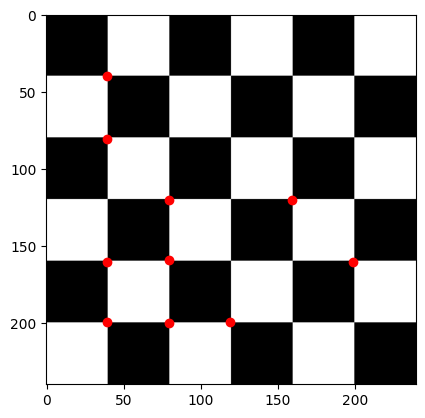

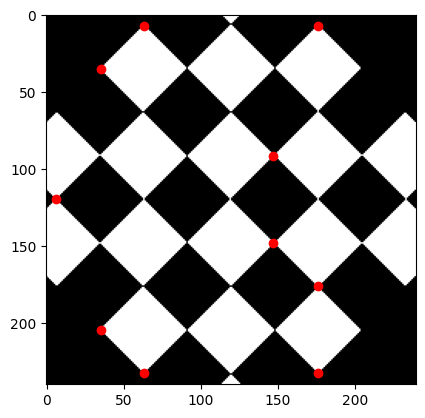

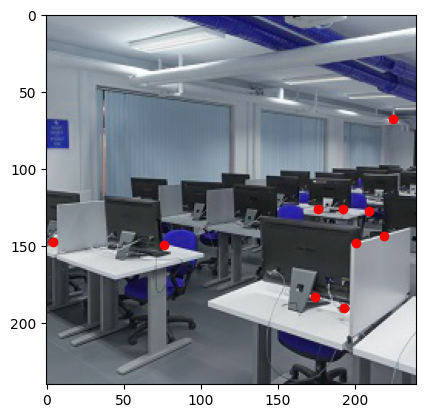

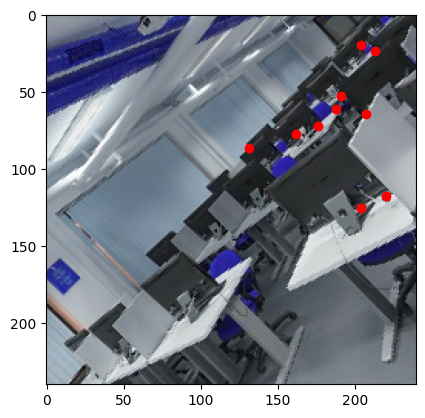

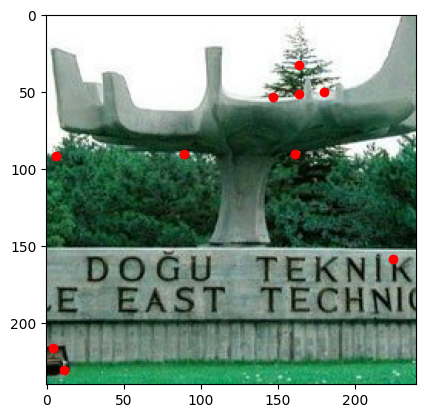

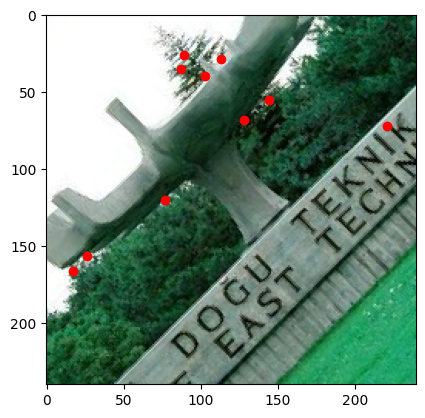

NAIVE AVERAGE TIME =  6.126496235529582


In [92]:

def naive_harris_corner_detector_supression(image, window_size=3):
    
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)



    offset = window_size // 2
    height, width = gray_image.shape

    directions = [
        [1, 1],
        [0, 1],
        [-1, 1],
        [-1, -1],
        [0, -1],
        [1, -1],
        [-1, 0],
        [1, 0]
    ]

    corners = np.zeros_like(gray_image, dtype=float)

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            window = gray_image[y-offset: y+offset+1, x-offset: x+offset+1]
            window = uniform_filtering(window)
            errors = np.zeros(8)
            ind = 0
            for direction in directions:
                if y-offset + direction[0] < 0 or y+offset+1 + direction[0] >= height or x-offset + direction[1] < 0 or x+offset+1 + direction[1] >= width:
                    continue

                new_window = gray_image[y-offset + direction[0]: y+offset+1 + direction[0], x-offset + direction[1]: x+offset+1 + direction[1]]
                errors[ind] = window_difference(window, new_window)
                ind += 1
            corners[y][x] = np.min(errors)


    #supressed for the avoid same corners
    supressed_corners = non_max_suppression(corners)

    
    top_10_indices = np.argpartition(supressed_corners.flatten(), -10)[-10:]

    
    top_10_indices_2d = np.unravel_index(top_10_indices, supressed_corners.shape)

    # plot the image
    plt.imshow(image)
    plt.gray()

    # plot the top 10 corners on the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()



naive_begin = time.time()
naive_harris_corner_detector_supression(input_image1)
naive_harris_corner_detector_supression(input_image2)
naive_harris_corner_detector_supression(input_image3)
naive_harris_corner_detector_supression(input_image4)
naive_harris_corner_detector_supression(input_image5)
naive_harris_corner_detector_supression(input_image6)
naive_end = time.time()

print("NAIVE AVERAGE TIME = ",(naive_end-naive_begin)/6)


#### PROS and CONS Naive Formula + Uniform Weighting (with Non-Maximum Suppression)

##### Pros
- It is simple algorithm and very easy to implement
- As it is using non-maximum suppression we can eliminate same corner results, and we can find more precise corners
- As we look for the all 8 directions around, when we rotate the picture we are still able to find corners but the top 10 corners just differ

##### Cons
- It is a slow approach, so it is not optimized, and as we can see from the average time it is not good option for time-limited tasks


## Taylor's Approximation + Uniform Weighting

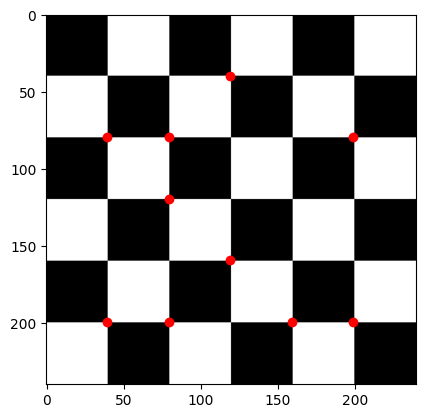

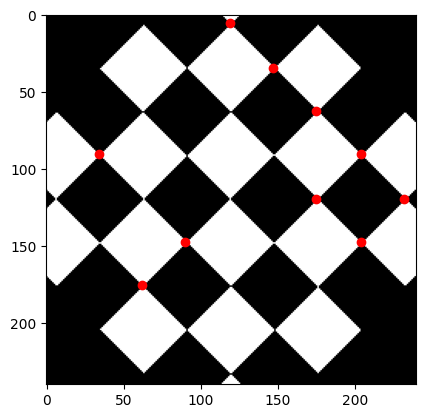

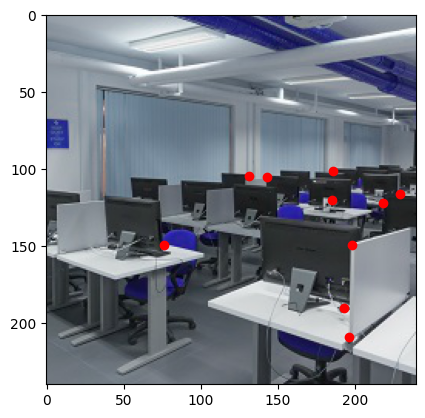

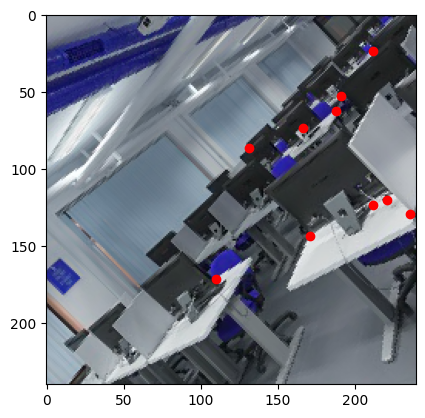

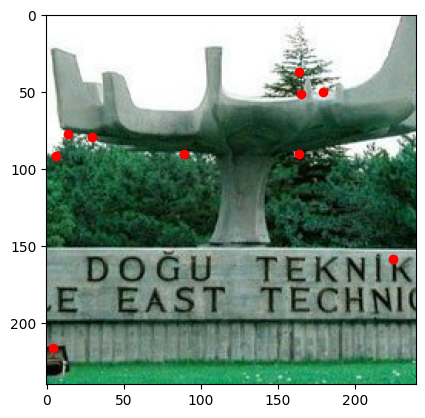

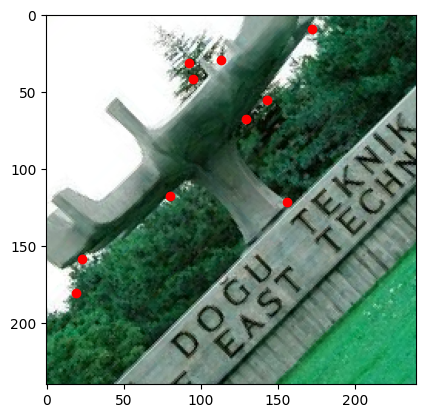

TAYLOR AVERAGE TIME =  1.3366658687591553


In [93]:

def taylors_approximation(image, window_size=3):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    offset = window_size // 2
    height, width = gray_image.shape

    directions = [
        [1, 1],
        [0, 1],
        [-1, 1],
        [-1, -1],
        [0, -1],
        [1, -1],
        [-1, 0],
        [1, 0]
    ]
    
    Ix, Iy = find_gradients(gray_image)
    corners = np.zeros_like(gray_image, dtype=float)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy



    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            #Summ of the gradient vectors for the window
            sum_of_xx = np.sum(Ixx[y-offset: y+offset+1, x-offset: x+offset+1])
            sum_of_yy = np.sum(Iyy[y-offset: y+offset+1, x-offset: x+offset+1])
            sum_of_xy = np.sum(Ixy[y-offset: y+offset+1, x-offset: x+offset+1])

            errors = np.zeros(8)
            ind = 0
            for direction in directions:
                if y-offset + direction[0] < 0 or y+offset+1 + direction[0] >= height or x-offset + direction[1] < 0 or x+offset+1 + direction[1] >= width:
                    continue

                errors[ind] = direction[0]**2 * sum_of_xx + 2 * direction[0] * direction[1] * sum_of_xy + direction[1]**2 * sum_of_yy
                ind += 1

            corners[y][x] = np.min(errors)



    supressed_corners = non_max_suppression(corners)

    # Find indices of the top 10 corners
    top_10_indices = np.argpartition(supressed_corners.flatten(), -10)[-10:]

    # Convert flattened indices to 2D indices
    top_10_indices_2d = np.unravel_index(top_10_indices, supressed_corners.shape)

    # Plot the image
    plt.imshow(image)
    plt.gray()

    # Plot the top 10 corners on top of the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()


taylor_begin = time.time()
taylors_approximation(input_image1)
taylors_approximation(input_image2)
taylors_approximation(input_image3)
taylors_approximation(input_image4)
taylors_approximation(input_image5)
taylors_approximation(input_image6)
taylor_end = time.time()

print("TAYLOR AVERAGE TIME = ",(taylor_end-taylor_begin)/6)


#### PROS and CONS Taylor's Approximation + Uniform Weighting (with Non-Maximum Suppression)

##### Pros
- It is faster than the naive approach, as we can see from the average times of these two algorithms we can see that using precalculated summations reduces time significantly
- As a result of using non-maximum supression, we are not finding same corner more than once
- As we look for the all 8 directions around, when we rotate the picture we are still able to find corners but the top 10 corners just differ
##### Cons
- It is still do many computations over the all image we can still optimize this approach in terms of time




## Fast Implementation + Uniform Weighting

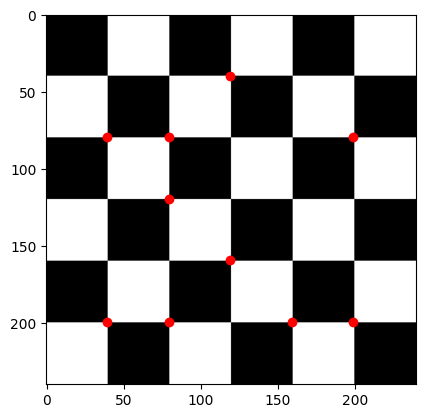

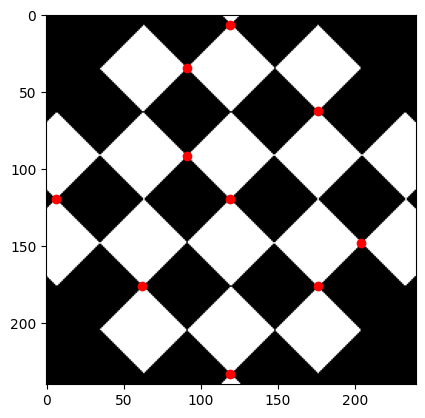

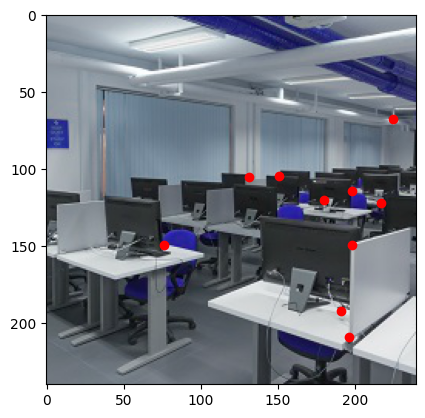

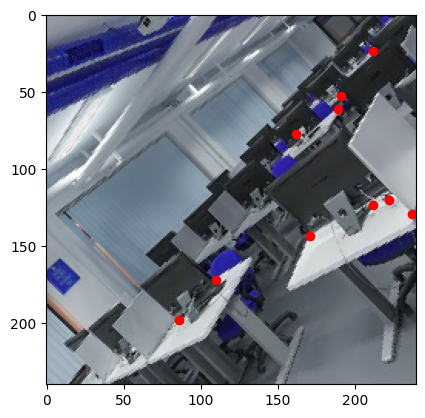

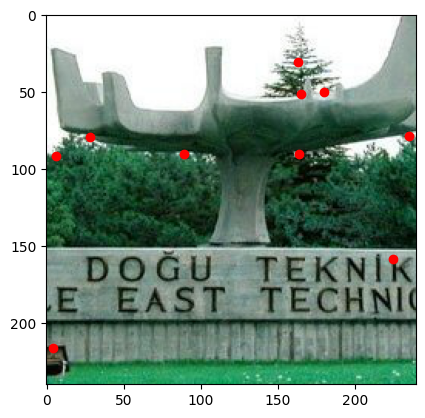

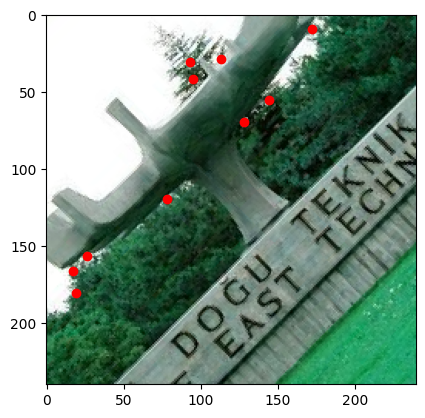

FAST AVERAGE TIME =  0.4827638069788615


In [94]:
# Write your code here

def fast_implementation_uniform(image):

    # convert image to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # find gradients of image
    Ix, Iy = find_gradients(gray_image)

    
    # corners = np.zeros_like(gray_image, dtype=float)
    
    # finding Ixx, Ixy, Iyy matrices
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # uniform filtering
    Ixx = uniform_filtering(Ixx)
    Iyy = uniform_filtering(Iyy)
    Ixy = uniform_filtering(Ixy)


    # for fast implementation our formula R is -> det(M) - K * Trace(M)^2
    # I took K as 0.04 because it fits with suggested value 0.04-0.06
    corners = (Ixx * Iyy - Ixy**2) - 0.04 * (Ixx + Iyy)**2
    


    # non max supression applied on corner values
    supressed_corners = non_max_suppression(corners)

    # find the top 10 corners
    top_10_indices = np.argpartition(supressed_corners.flatten(), -10)[-10:]

    # convert flattened indices to 2D indices for using plotting on image
    top_10_indices_2d = np.unravel_index(top_10_indices, supressed_corners.shape)

    # plot the image
    plt.imshow(image)


    # plot the top 10 corners on  the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()


fast_begin = time.time()
fast_implementation_uniform(input_image1)
fast_implementation_uniform(input_image2)
fast_implementation_uniform(input_image3)
fast_implementation_uniform(input_image4)
fast_implementation_uniform(input_image5)
fast_implementation_uniform(input_image6)
fast_end = time.time()

print("FAST AVERAGE TIME = ",(fast_end-fast_begin)/6)


#### PROS and CONS Fast Implementation + Uniform Weighting (with Non-Maximum Suppression)

##### Pros
- It is faster than the both naive and Taylor approach, as we can see from the average times of these three algorithms we can see that using precalculated R values which are equal to det(M) - K * Trace(M)^2 method reduces algorithm time significantly.

- As a result of using non-maximum supression, we are not finding same corner more than once.

- As we look for the matrixes lambda responses, our algorithm is rotation invariance again, but still top 10 Corners may not be coincide.

##### Cons
- As it is using some approximations by using lambda values it is much faster than the others, but this may cause some inaccuracies in some complex images, but it does not case in our inputs above.




## Fast Implementation + Circular Weighting

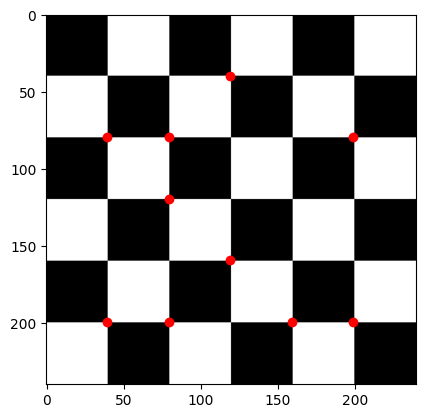

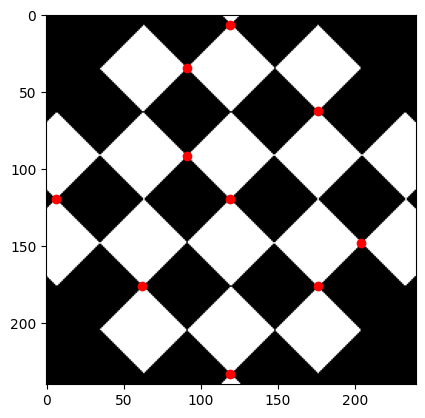

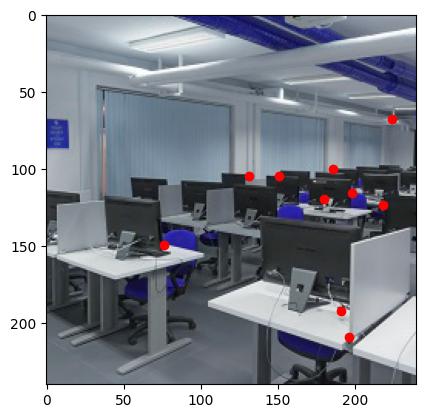

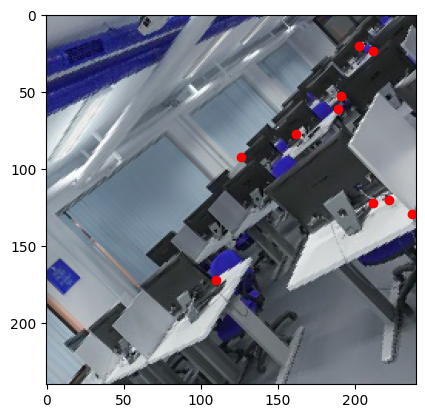

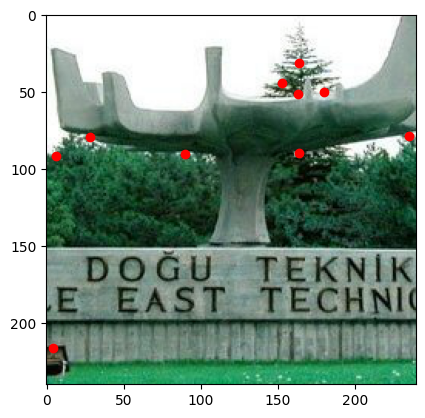

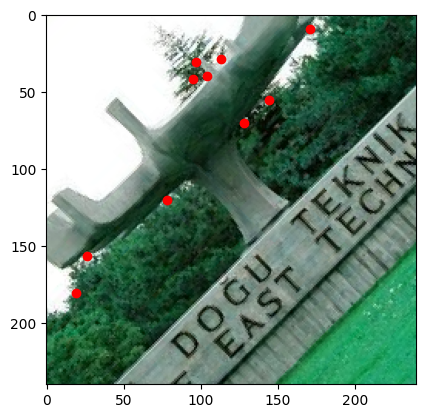

FAST AVERAGE TIME =  0.49793076515197754


In [95]:
# Write your code here
# Write your code here

def fast_implementation_circular(image):

    # convert image to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # find gradients of image
    Ix, Iy = find_gradients(gray_image)

    
    # corners = np.zeros_like(gray_image, dtype=float)
    
    # finding Ixx, Ixy, Iyy matrices
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # uniform filtering
    Ixx = circular_filtering(Ixx)
    Iyy = circular_filtering(Iyy)
    Ixy = circular_filtering(Ixy)


    # for fast implementation our formula R is -> det(M) - K * Trace(M)^2
    # I took K as 0.04 because it fits with suggested value 0.04-0.06
    corners = (Ixx * Iyy - Ixy**2) - 0.04 * (Ixx + Iyy)**2
    


    # non max supression applied on corner values
    supressed_corners = non_max_suppression(corners)

    # find the top 10 corners
    top_10_indices = np.argpartition(supressed_corners.flatten(), -10)[-10:]

    # convert flattened indices to 2D indices for using plotting on image
    top_10_indices_2d = np.unravel_index(top_10_indices, supressed_corners.shape)

    # plot the image
    plt.imshow(image)


    # plot the top 10 corners on  the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()

fast_begin = time.time()
fast_implementation_circular(input_image1)
fast_implementation_circular(input_image2)
fast_implementation_circular(input_image3)
fast_implementation_circular(input_image4)
fast_implementation_circular(input_image5)
fast_implementation_circular(input_image6)
fast_end = time.time()



print("FAST AVERAGE TIME = ",(fast_end-fast_begin)/6)


#### PROS and CONS Fast Implementation + Circular Weighting (with Non-Maximum Suppression)

##### Pros
- It is faster than the both naive and Taylor approach, as we can see from the average times of these three algorithms we can see that using precalculated R values which are equal to det(M) - K * Trace(M)^2 method reduces algorithm time significantly.

- As a result of using non-maximum supression, we are not finding same corner more than once.

- As we look for the matrixes lambda responses, our algorithm is rotation invariance again, but still top 10 Corners may not be coincide.


##### Cons
- As it is using some approximations by using lambda values it is much faster than the others, but this may cause some inaccuracies in some complex images, but it does not case in our inputs above.


##### Differences between uniform
- As we applied circular weighting it helps us to find corners more precise than uniform weighting, because in circular approach we are eliminating the corners which are away from the center, and this helps to eliminate noisy or irrelevant pixels. However, we can say that from comparison of results of these two filters' effects are very similar to each other in above images.
- There is not much time difference

## Fast Implementation + Gaussian Weighting

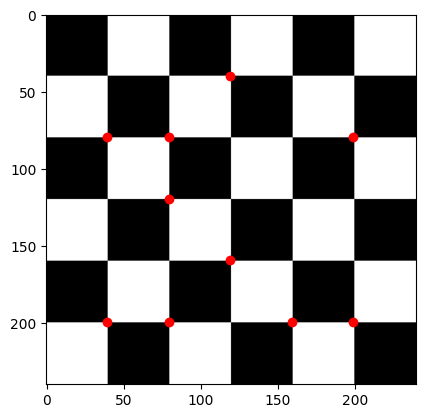

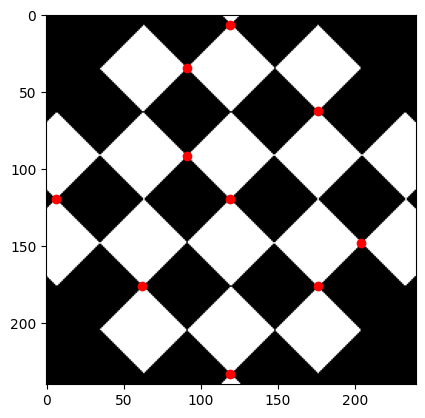

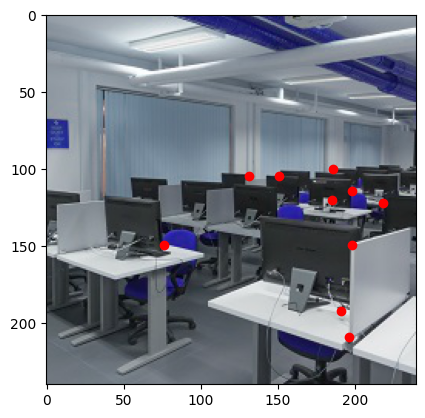

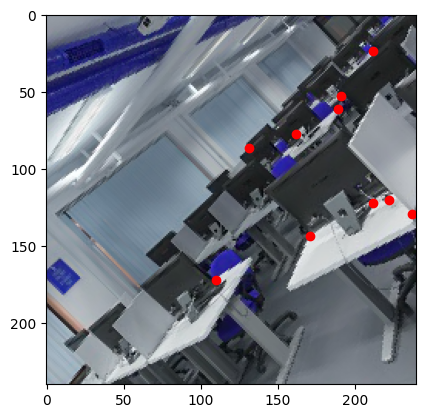

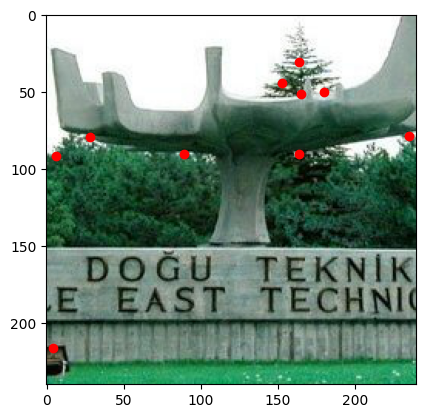

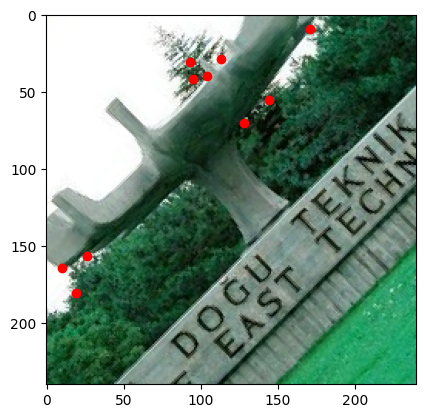

FAST AVERAGE TIME =  0.4852687517801921


In [96]:


def fast_implementation_gaussian(image):

    # convert image to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # find gradients of image
    Ix, Iy = find_gradients(gray_image)

    
    # corners = np.zeros_like(gray_image, dtype=float)
    
    # finding Ixx, Ixy, Iyy matrices
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # uniform filtering
    Ixx = gaussian_filtering(Ixx)
    Iyy = gaussian_filtering(Iyy)
    Ixy = gaussian_filtering(Ixy)


    # for fast implementation our formula R is -> det(M) - K * Trace(M)^2
    # I took K as 0.04 because it fits with suggested value 0.04-0.06
    corners = (Ixx * Iyy - Ixy**2) - 0.04 * (Ixx + Iyy)**2
    


    # non max supression applied on corner values
    supressed_corners = non_max_suppression(corners)

    # find the top 10 corners
    top_10_indices = np.argpartition(supressed_corners.flatten(), -10)[-10:]

    # convert flattened indices to 2D indices for using plotting on image
    top_10_indices_2d = np.unravel_index(top_10_indices, supressed_corners.shape)

    # plot the image
    plt.imshow(image)


    # plot the top 10 corners on  the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()

fast_begin = time.time()
fast_implementation_gaussian(input_image1)
fast_implementation_gaussian(input_image2)
fast_implementation_gaussian(input_image3)
fast_implementation_gaussian(input_image4)
fast_implementation_gaussian(input_image5)
fast_implementation_gaussian(input_image6)
fast_end = time.time()


print("FAST AVERAGE TIME = ",(fast_end-fast_begin)/6)


#### PROS and CONS Fast Implementation + Gaussian Weighting (with Non-Maximum Suppression)

##### Pros
- It is faster than the both naive and Taylor approach, as we can see from the average times of these three algorithms we can see that using precalculated R values which are equal to det(M) - K * Trace(M)^2 method reduces algorithm time significantly.

- As a result of using non-maximum supression, we are not finding same corner more than once.

- As we look for the matrixes lambda responses, our algorithm is rotation invariance again, but still top 10 Corners may not be coincide.


##### Cons
- As it is using some approximations by using lambda values it is much faster than the others, but this may cause some inaccuracies in some complex images, but it does not case in our inputs above.


##### Differences with uniform and circular
- As we applied gaussian weighting it helps us to find corners more precise than the uniform and circular weightings, because by assigning lower weights to pixels farther from the center, Gaussian weighting inherently reduces the influence of noisy or irrelevant pixels, therefore it helps us to find correct pixels more precise.

but all the weightings we used above are helping us to discover corners, and we can not see much difference between them among these images' results, may be results may change in some complex images.


## Fast Implementation + Gaussian Weighting + RGB Split

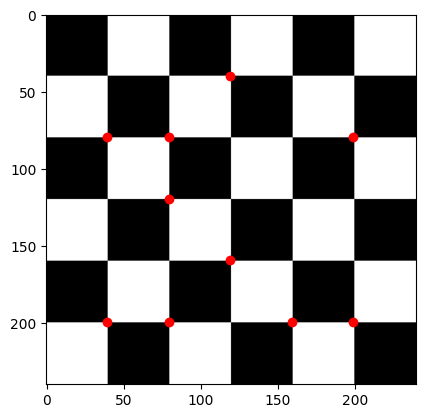

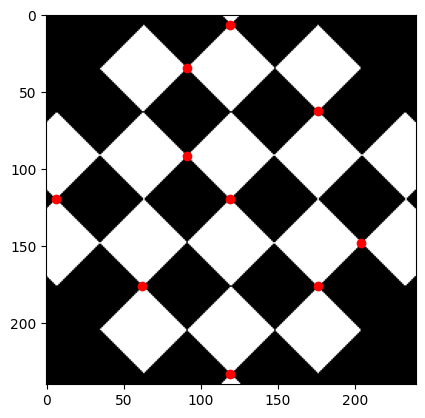

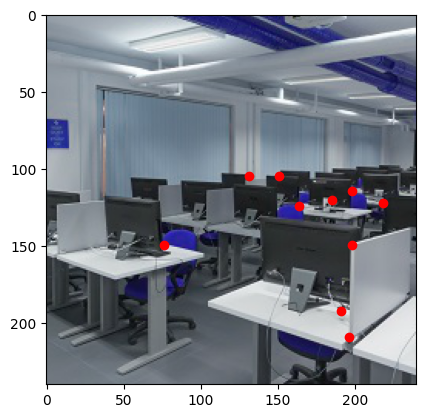

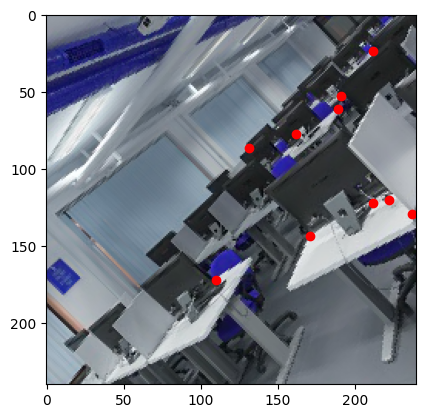

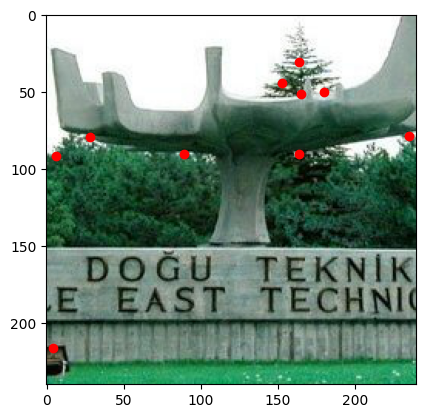

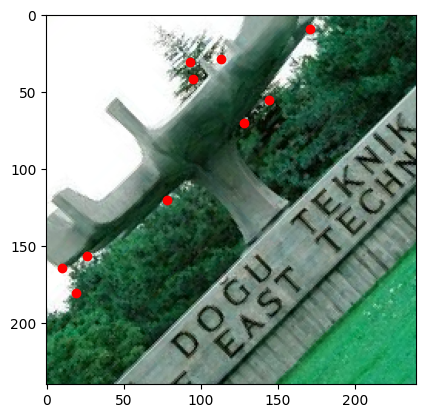

FAST AVERAGE TIME =  0.5278819799423218


In [97]:
# Write your code here

def fast_implementation_gaussian_rgb_split(image):

    # split the RGB channels
    blue_channel, green_channel, red_channel = cv2.split(image)

    # total corners matrix
    total_corners = np.zeros_like(blue_channel, dtype=float)

    # Apply the algorithm on each channel separately
    for channel in [blue_channel, green_channel, red_channel]:

        # Find gradients of the channel
        Ix, Iy = find_gradients(channel)

        # Find Ixx, Ixy, Iyy matrices
        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy

        # Uniform filtering
        Ixx = gaussian_filtering(Ixx)
        Iyy = gaussian_filtering(Iyy)
        Ixy = gaussian_filtering(Ixy)

        # Calculate corner response for this channel
        corners = (Ixx * Iyy - Ixy**2) - 0.04 * (Ixx + Iyy)**2

        # Accumulate the response in the total_corners matrix
        total_corners += corners

    # Non-maximum suppression
    supressed_corners = non_max_suppression(total_corners)

    # Find the top 10 corners
    top_10_indices = np.argpartition(supressed_corners.flatten(), -10)[-10:]

    # Convert flattened indices to 2D indices for using plotting on image
    top_10_indices_2d = np.unravel_index(top_10_indices, supressed_corners.shape)

    # Plot the image
    plt.imshow(image)

    # Plot the top 10 corners on the image
    plt.scatter(top_10_indices_2d[1], top_10_indices_2d[0], c='red', marker='o')

    plt.show()




fast_begin = time.time()
fast_implementation_gaussian_rgb_split(input_image1)
fast_implementation_gaussian_rgb_split(input_image2)
fast_implementation_gaussian_rgb_split(input_image3)
fast_implementation_gaussian_rgb_split(input_image4)
fast_implementation_gaussian_rgb_split(input_image5)
fast_implementation_gaussian_rgb_split(input_image6)
fast_end = time.time()


print("FAST AVERAGE TIME = ",(fast_end-fast_begin)/6)



#### PROS and CONS Fast Implementation + Gaussian Weighting + RGB Split (with Non-Maximum Suppression)

##### Pros
- It is faster than the both naive and Taylor approach, as we can see from the average times of these three algorithms we can see that using precalculated R values which are equal to det(M) - K * Trace(M)^2 method reduces algorithm time significantly.

- As a result of using non-maximum supression, we are not finding same corner more than once.

- As we look for the matrixes lambda responses, our algorithm is rotation invariance again, but still top 10 Corners may not be coincide.


##### Cons
- As it is using some approximations by using lambda values it is much faster than the others, but this may cause some inaccuracies in some complex images, but it does not case in our inputs above.


##### Differences between gray scale
- As we used all three channel for finding corner responses and then sum them up to see total corner responses among images, results are not effected much. However, in some cases
which includes more similar color tones, the results may differ, and using three channel corner detection may not be convenient in such cases.
- Just calculating all channels rather than just one grayscale image, it causes time cost.


# Conclusion
To sum up, from our approaches, we can select the appropriate approach by looking for our needs.
For example, if we have time limit we should go with Fast implementation, if we want more accuracy then we may look for the image specifications and may use taylor's method.

From these approaches, I believe the best approach is Fast implementation with Gaussian weighting, because it is significantly faster than other methods, and also it gives good results with respect to it's high speed. Among the weightings, I believe the best one is Gaussian as it gives more importance on centers, and helps us to eliminate noises on images. Finally, I would select gray scale for detecting corners, because RGB channels do not give accurate results in all images, results of RGB channels may change depend on the image tones and colors, so it is not convenient way to use in all cases. As a result from these reasons, I would use Fast implementation with Gaussian Weighting.
